In [44]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load linear & displacement fields for single Quijote sim

In [183]:
n_grid = 512
box_size = 1000.0
interlacing = True
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

In [184]:
# Quijote LH test data

idx_LH_str = '0663'
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote'

fn_sim = f'{dir_mocks}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
sim_disp = np.load(fn_sim)

fn_lin = f'{dir_mocks}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin = np.load(fn_lin)[0]

In [185]:
sim_disp.shape, dens_lin.shape

((3, 512, 512, 512), (512, 512, 512))

Add displacements to grid

In [186]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-05-30 18:19:49,142 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [187]:
grid.shape, sim_pos.shape

((512, 512, 512, 3), (134217728, 3))

Put displacements on mesh

In [189]:
sim_pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim_pos, vel=None, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(sim_pos_mesh.shape)

2024-05-30 18:20:15,407 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-30 18:20:15,409 bacco.statistics : starting deposit 1
2024-05-30 18:20:19,580 bacco.statistics :  mesh done in 4.17 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 512, 512, 512)


In [190]:
sim_pos_mesh_interlacing = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim_pos, vel=None, mass=None,
                 interlacing=True, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(sim_pos_mesh_interlacing.shape)

2024-05-30 18:21:01,685 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-30 18:21:01,686 bacco.statistics : starting deposit 1
2024-05-30 18:21:09,825 bacco.statistics :  mesh done in 8.14 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(2, 512, 512, 512)


-15.643541 14.582848
-15.643541 14.582848


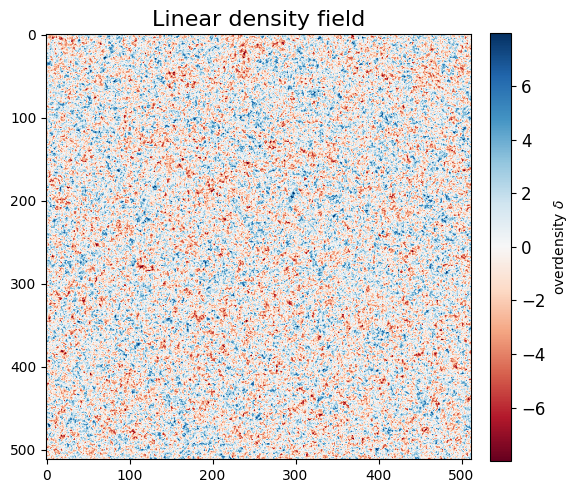

In [103]:
plotter.plot_overdensity_field(dens_lin, title=r'Linear density field',
                               #vmax=0.1
                               )

0.0 1313.9625
0.0 1313.9625


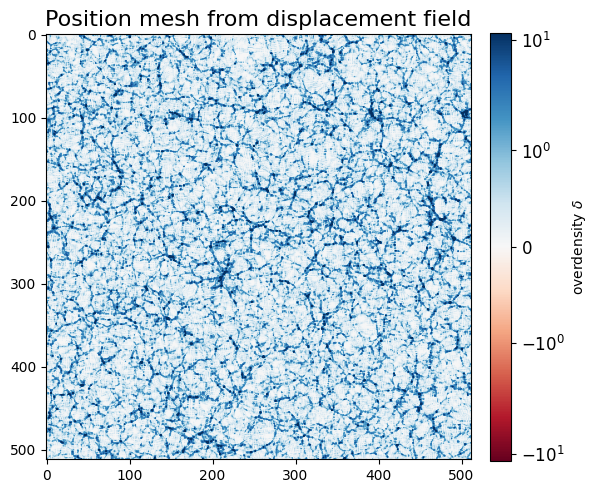

In [105]:
plotter.plot_overdensity_field(sim_pos_mesh[0], title=r'Position mesh from displacement field',
                               symlog=True, #vmax=0.1
                               )

### Set up power spectrum computation

In [9]:
def get_cosmo(param_dict):
    a_scale = 1
    # omega_m = omega_cold + omega_neutrinos 
    # (omega_m = omega_cold if no neutrinos) 
    # Om_cdm = Om_cold - Om_baryon
    if 'omega_m' in param_dict:
        omega_cdm = param_dict['omega_m']-param_dict['omega_baryon']
    elif 'omega_cold' in param_dict:
        omega_cdm = param_dict['omega_cold']-param_dict['omega_baryon']
    else:
        raise ValueError("param_dict must include omega_m or omega_cold!")

    cosmopars = dict(
            omega_cdm=omega_cdm,
            omega_baryon=param_dict['omega_baryon'],
            hubble=param_dict['h'],
            ns=param_dict['n_s'],
            sigma8=param_dict['sigma_8'],
            tau=0.0561,
            A_s=None,
            neutrino_mass=0.,
            w0=-1,
            wa=0,
        )

    cosmo = bacco.Cosmology(**cosmopars)
    cosmo.set_expfactor(a_scale)
    return cosmo

In [10]:
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))
cosmo_Quijote = get_cosmo(param_dict)

2024-05-28 11:50:41,617 bacco.cosmo :    initialization took 0.000 secs


In [192]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

args_power = {'ngrid':n_grid,
            'box':box_size,
            'cosmology':cosmo_Quijote,
            #'interlacing':interlacing,
            'kmin':k_min,
            'kmax':k_max,
            'nbins':n_bins,
            'correct_grid':True,
            'log_binning':log_binning,
            'deposit_method':'cic', #check??
            'compute_correlation':False,
            'zspace':False,
            'compute_power2d':False}

bacco.configuration.update({'number_of_threads': n_threads})

### Compute power spectra of fields / particle positions

In [25]:
pk_obj_particles = bacco.statistics.compute_powerspectrum(
    ngrid=n_grid,
    box=box_size,
    pos=sim_pos,
    vel=None,
    mass=None,
    interlacing=interlacing,
    unit_in_Mpc=1, #?? fac of h?
    #deposit_method='tsc',
    deposit_method='cic',
    bs_method=None,
    log_binning=log_binning,
    kmin=k_min,
    kmax=k_max,
    nbins=n_bins,
    correct_grid=True,
    # deconvolve_grid = True,
    deconvolve_grid = False,
    normalise_grid = True, # needed this true to fix!!
    #normalise_grid = False,
    cosmology=cosmo_Quijote,
    pmulti_interp='polyfit',
    nthreads=n_threads,
)

2024-05-28 12:08:32,325 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-05-28 12:08:32,328 bacco.statistics :  setting the grid 512 True
2024-05-28 12:08:32,329 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-28 12:08:32,329 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0


2024-05-28 12:08:41,353 bacco.statistics :  mesh done in 9.02 s
2024-05-28 12:08:41,355 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.164206 sec
bacco.power : Counting modes


2024-05-28 12:08:44,722 bacco.statistics :  done compute.power
2024-05-28 12:08:44,725 bacco.util : pk multipoles at k 0.010826366669103445 set to zero: it seems you have a lot of bins for this grid size
/scratch/kstoreyf/baccogit/bacco/statistics.py:1820: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-05-28 12:08:44,800 bacco.util : pk multipoles at k 1.0826367986778034 set to zero: it seems you have a lot of bins for this grid size
2024-05-28 12:08:44,801 bacco.statistics :  power done in 12.5 s


bacco.power : done counting modes in 0.905523 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.685555 secs
bacco.power : Deallocating arrays


In [112]:
pk_obj_particles_deconv = bacco.statistics.compute_powerspectrum(
    ngrid=n_grid,
    box=box_size,
    pos=sim_pos,
    vel=None,
    mass=None,
    interlacing=interlacing,
    unit_in_Mpc=1, #?? fac of h?
    #deposit_method='tsc',
    deposit_method='cic',
    bs_method=None,
    log_binning=log_binning,
    kmin=k_min,
    kmax=k_max,
    nbins=n_bins,
    correct_grid=True,
    # deconvolve_grid = True,
    deconvolve_grid = True,
    normalise_grid = True, # needed this true to fix!!
    #normalise_grid = False,
    cosmology=cosmo_Quijote,
    pmulti_interp='polyfit',
    nthreads=n_threads,
)

2024-05-30 16:38:34,140 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-05-30 16:38:34,142 bacco.statistics :  setting the grid 512 True
2024-05-30 16:38:34,142 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-30 16:38:34,143 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0


2024-05-30 16:38:43,202 bacco.statistics :  mesh done in 9.06 s
2024-05-30 16:38:43,205 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.035769 sec
bacco.power : Counting modes


2024-05-30 16:38:46,402 bacco.statistics :  done compute.power
2024-05-30 16:38:46,405 bacco.util : pk multipoles at k 0.010826366669103445 set to zero: it seems you have a lot of bins for this grid size
/scratch/kstoreyf/baccogit/bacco/statistics.py:1820: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-05-30 16:38:46,479 bacco.util : pk multipoles at k 1.0826367986778034 set to zero: it seems you have a lot of bins for this grid size
2024-05-30 16:38:46,480 bacco.statistics :  power done in 12.3 s


bacco.power : done counting modes in 0.937502 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.641470 secs
bacco.power : Deallocating arrays


In [208]:
pk_obj_particles_deconv_nointerlacing = bacco.statistics.compute_powerspectrum(
    ngrid=n_grid,
    box=box_size,
    pos=sim_pos,
    vel=None,
    mass=None,
    interlacing=False,
    unit_in_Mpc=1, #?? fac of h?
    #deposit_method='tsc',
    deposit_method='cic',
    bs_method=None,
    log_binning=log_binning,
    kmin=k_min,
    kmax=k_max,
    nbins=n_bins,
    correct_grid=True,
    # deconvolve_grid = True,
    deconvolve_grid = True,
    normalise_grid = True, # needed this true to fix!!
    #normalise_grid = False,
    cosmology=cosmo_Quijote,
    pmulti_interp='polyfit',
    nthreads=n_threads,
)

2024-05-30 18:33:40,482 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-30 18:33:40,484 bacco.statistics :  setting the grid 512 False
2024-05-30 18:33:40,485 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-30 18:33:40,486 bacco.statistics : starting deposit 1
2024-05-30 18:33:44,641 bacco.statistics :  mesh done in 4.16 s
2024-05-30 18:33:44,643 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0


2024-05-30 18:33:47,114 bacco.statistics :  done compute.power
2024-05-30 18:33:47,118 bacco.util : pk multipoles at k 0.010826366669103445 set to zero: it seems you have a lot of bins for this grid size
/scratch/kstoreyf/baccogit/bacco/statistics.py:1820: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-05-30 18:33:47,191 bacco.util : pk multipoles at k 1.0826367986778034 set to zero: it seems you have a lot of bins for this grid size
2024-05-30 18:33:47,192 bacco.statistics :  power done in 6.71 s


bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.506462 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.815142 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.635626 secs
bacco.power : Deallocating arrays


In [157]:
np.max(sim_pos), box_size

(999.99994, 1000.0)

In [172]:
pk_obj_particles_deconv_check = bacco.statistics.compute_powerspectrum(
    ngrid=n_grid,
    box=box_size,
    pos=sim_pos,
    vel=None,
    mass=None,
    interlacing=interlacing,
    unit_in_Mpc=1,
    #unit_in_Mpc=1*cosmo_Quijote.pars['hubble'], #?? fac of h?
    #deposit_method='tsc',
    deposit_method='cic',
    bs_method=None,
    log_binning=log_binning,
    kmin=k_min,
    kmax=k_max,
    nbins=n_bins,
    correct_grid=False,
    # deconvolve_grid = True,
    deconvolve_grid = True,
    normalise_grid = True, # needed this true to fix!!
    #normalise_grid = False,
    cosmology=cosmo_Quijote,
    pmulti_interp='polyfit',
    nthreads=n_threads,
)

2024-05-30 17:54:53,365 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-30 17:54:53,367 bacco.statistics :  setting the grid 512 False
2024-05-30 17:54:53,368 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-30 17:54:53,369 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0


2024-05-30 17:54:57,729 bacco.statistics :  mesh done in 4.36 s
2024-05-30 17:54:57,731 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.522707 sec
bacco.power : Counting modes


2024-05-30 17:55:00,196 bacco.statistics :  done compute.power
2024-05-30 17:55:00,199 bacco.util : pk multipoles at k 0.010826366669103445 set to zero: it seems you have a lot of bins for this grid size
/scratch/kstoreyf/baccogit/bacco/statistics.py:1820: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-05-30 17:55:00,273 bacco.util : pk multipoles at k 1.0826367986778034 set to zero: it seems you have a lot of bins for this grid size
2024-05-30 17:55:00,274 bacco.statistics :  power done in 6.91 s


bacco.power : done counting modes in 0.823465 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.664116 secs
bacco.power : Deallocating arrays


In [31]:
kk = pk_obj_particles['k']

In [193]:

pk_obj_mesh = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh,
                    grid2=sim_pos_mesh,
                    normalise_grid1=True,
                    normalise_grid2=True,
                    deconvolve_grid1=False,
                    deconvolve_grid2=False,
                    interlacing=False,
                    **args_power)

2024-05-30 18:23:36,844 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.029355 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.762107 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000154 secs
bacco.power : Deallocating arrays


2024-05-30 18:23:41,552 bacco.statistics :  ...done in 4.71 s


In [142]:
assert np.allclose(pk_obj_particles['pk'], pk_obj_mesh['pk'], rtol=0.01)

In [194]:

pk_obj_mesh_deconv = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh,
                    grid2=sim_pos_mesh,
                    normalise_grid1=True,
                    normalise_grid2=True,
                    deconvolve_grid1=True,
                    deconvolve_grid2=True,
                    interlacing=False,
                    **args_power)

2024-05-30 18:24:00,976 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.014880 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.770783 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


2024-05-30 18:24:05,607 bacco.statistics :  ...done in 4.63 s


In [195]:

# passing an interlaced grid does nothing if interlacing=False (same as non-interlaced grid)
# using interlacing = True fails if pass non-interlaced grid
# slight diffs in values at high-k if both interlaced vs both not-interlaced
pk_obj_mesh_deconv_interlacing = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh_interlacing,
                    grid2=sim_pos_mesh_interlacing,
                    normalise_grid1=True,
                    normalise_grid2=True,
                    deconvolve_grid1=True,
                    deconvolve_grid2=True,
                    interlacing=True,
                    **args_power)

2024-05-30 18:24:22,109 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.996547 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.913234 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000160 secs
bacco.power : Deallocating arrays


2024-05-30 18:24:30,213 bacco.statistics :  ...done in 8.1 s


In [204]:
pk_obj_particles_deconv['pk']

array([30440.31017151, 20162.00764484, 24147.49813694, 12576.92021349,
       18149.83098693, 22487.3932973 , 18143.80943028, 17785.4170488 ,
       15360.36636527, 13792.77911732, 11346.66194672, 10287.32293535,
        9217.04467152,  7165.87986718,  5685.18244372,  4663.31395324,
        3988.75581841,  3064.17960832,  2536.25220738,  2058.40002011,
        1699.24911478,  1384.98870502,  1156.61271298,   978.77320533,
         828.79370636,   709.10437381,   608.51008583,   523.60692934,
         449.96332149,     0.        ])

In [209]:
pk_obj_particles_deconv_nointerlacing['pk']

array([30440.30747333, 20162.01865658, 24147.49055523, 12576.9136748 ,
       18149.81866524, 22487.40278362, 18143.79962248, 17785.43739116,
       15360.37089936, 13792.80734002, 11346.66466237, 10287.34212102,
        9217.06259779,  7165.85720918,  5685.19026643,  4663.33012162,
        3988.76092933,  3064.19407727,  2536.28552407,  2058.45580755,
        1699.2665119 ,  1385.04521069,  1156.68988857,   978.88710404,
         828.95667709,   709.38520071,   609.07071451,   524.73249668,
         452.28530413,     0.        ])

In [205]:
pk_obj_mesh_deconv['pk']

array([30439.00119116, 20165.63347166, 24150.3115815 , 12576.65421346,
       18148.96121923, 22498.29633489, 18142.67514011, 17780.80196587,
       15359.33850656, 13791.19930836, 11347.12437988, 10288.89435474,
        9222.38397323,  7167.42355984,  5690.20239558,  4667.49445126,
        3995.84118923,  3068.50311669,  2531.41624854,  2058.09301355,
        1701.60947414,  1385.81813781,  1159.94139861,   979.13313469,
         829.21812892,   709.32750305,   609.03105671,   524.75590855,
         452.28905969,     0.        ])

In [206]:
pk_obj_mesh_deconv_interlacing['pk']

array([30439.00388921, 20165.62245794, 24150.31916423, 12576.66075345,
       18148.97353675, 22498.28684492, 18142.68494859, 17780.78163324,
       15359.33396942, 13791.17109001, 11347.1216637 , 10288.87515198,
        9222.36605734,  7167.4462331 ,  5690.19455822,  4667.47824984,
        3995.83607283,  3068.48863286,  2531.38295442,  2058.0372524 ,
        1701.59200472,  1385.76162211,  1159.86397095,   979.01921166,
         829.05511231,   709.04670014,   608.47046292,   523.63029081,
         449.96706358,     0.        ])

In [144]:
assert np.allclose(pk_obj_particles_deconv['pk'], pk_obj_mesh_deconv['pk'], rtol=0.01)

### Load in emulators, compute emu P(k)'s

In [28]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'omega_baryon': 'omega_baryon',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names if param_name in param_names_2_emu_param_names]

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [32]:
for param_name in param_names:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

### Quijote via globus

In [65]:
dir_quijote_pks = f'/dipc/kstoreyf/Quijote_simulations/Pk/matter/latin_hypercube/{int(idx_LH_str)}'
fn_quijote_pk = f'{dir_quijote_pks}/Pk_m_z=0.txt'
print(fn_quijote_pk)
k_quijote, pk_quijote = np.loadtxt(fn_quijote_pk, unpack=True)

/dipc/kstoreyf/Quijote_simulations/Pk/matter/latin_hypercube/663/Pk_m_z=0.txt


In [175]:
import readgadget
dir_quijote_snaps = f'/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{int(idx_LH_str)}'
snapshot = f'{dir_quijote_snaps}/snapdir_004/snap_004' # 004 = z0
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)
#header   = readgadget.header(snapshot)
#print(header)
pos_snap = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel_snap = readgadget.read_block(snapshot, "VEL ", ptype)

In [164]:
pk_obj_snap = bacco.statistics.compute_powerspectrum(
    ngrid=n_grid,
    box=box_size,
    pos=pos_snap,
    vel=None,
    mass=None,
    interlacing=True,
    unit_in_Mpc=1, #?? fac of h?
    #deposit_method='tsc',
    deposit_method='cic',    
    bs_method=None,
    log_binning=log_binning,
    kmin=k_min,
    kmax=k_max,
    nbins=n_bins,
    correct_grid=True,
    deconvolve_grid = True,
    normalise_grid = True, # needed this true to fix!!
    #normalise_grid = False,
    cosmology=cosmo_Quijote,
    pmulti_interp='polyfit',
    nthreads=n_threads,
)

2024-05-30 17:47:26,736 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-05-30 17:47:26,739 bacco.statistics :  setting the grid 512 True
2024-05-30 17:47:26,740 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-30 17:47:26,740 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0


2024-05-30 17:47:34,618 bacco.statistics :  mesh done in 7.88 s
2024-05-30 17:47:34,621 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.942154 sec
bacco.power : Counting modes


2024-05-30 17:47:38,707 bacco.statistics :  done compute.power
2024-05-30 17:47:38,712 bacco.util : pk multipoles at k 0.010826366669103445 set to zero: it seems you have a lot of bins for this grid size
/scratch/kstoreyf/baccogit/bacco/statistics.py:1820: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-05-30 17:47:38,788 bacco.util : pk multipoles at k 1.0826367986778034 set to zero: it seems you have a lot of bins for this grid size
2024-05-30 17:47:38,789 bacco.statistics :  power done in 12.1 s


bacco.power : done counting modes in 0.945014 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.632804 secs
bacco.power : Deallocating arrays


### Plot

/tmp/ipykernel_382472/2379103202.py:54: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_382472/2379103202.py:55: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


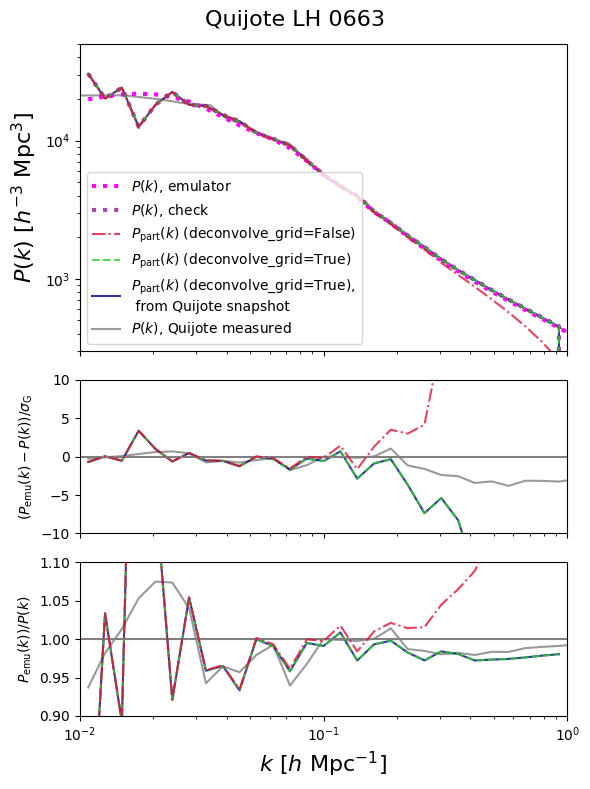

In [174]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
          #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
          r'$P_\text{part}(k)$ (deconvolve_grid=True)',
          #r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
          r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
          ]
#colors = ['black', 'purple', 'green', 'salmon', 'cornflowerblue']
colors = ['crimson', 'limegreen', 'darkblue']
#lss = ['-', '--', '-', '--', '-']
lss = ['-.', '--', '-']
zorders = [3, 2, 1, 0]
pk_objs = [pk_obj_particles, 
           #pk_obj_mesh, 
           pk_obj_particles_deconv,
           #pk_obj_particles_deconv_Mpcperh, 
           #pk_obj_pos_mesh_deconv, 
           pk_obj_snap]
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

ks.append(k_quijote)
pks.append(pk_quijote)
errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
labels.append(r'$P(k)$, Quijote measured')
colors.append('grey')
lss.append('-')
zorders.append(0)


#pks[1]/= cosmo_Quijote.pars['hubble']**3

plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color=color_pk_emu, lw=3)
ax.loglog(pk_obj_particles_deconv_check['k'],#*cosmo_Quijote.pars['hubble'], 
          pk_obj_particles_deconv_check['pk'],#*cosmo_Quijote.pars['hubble']**3, 
          label=r'$P(k)$, check', ls=':', color='purple', lw=3, alpha=0.7)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
#ax2.set_ylabel(r'$(P(k)-P_\text{map2map}(k))$'+'\n'+r'$/P_\text{map2map}(k)$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
#ax2.set_ylim(-0.1, 0.1)
ax2.set_ylim(0.9, 1.1)
#ax2.set_ylim(0.5, 1.5)


ax.legend(fontsize=10, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

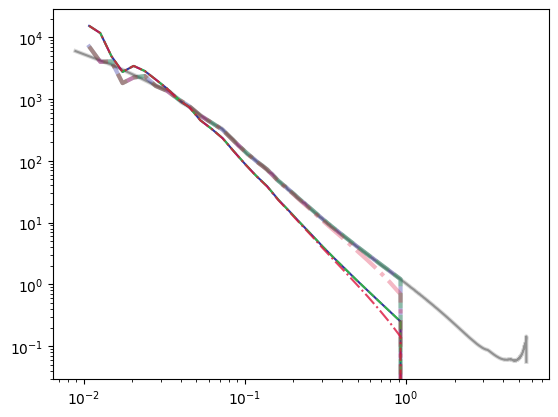

In [180]:
plt.figure()
ax = plt.gca()
for i in range(len(pks)):
    err_approx = bacco.statistics.approx_pk_gaussian_error(ks[i], pks[i], box_size)
    ax.plot(ks[i], err_approx, ls=lss[i], lw=3, label=labels[i], color=colors[i], alpha=0.3, zorder=zorders[i])

    ax.plot(ks[i], errs[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])

    # if len(pk_emu)!=len(pks[i]):
    #     pk_interp = np.interp(kk, ks[i], pks[i])
    #     err_interp = np.interp(kk, ks[i], errs[i])
    #     ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # else:
    #     ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])

plt.xscale('log')
plt.yscale('log')